In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Overview:
In recent years, Twitter has emerged as a prominent platform for marketing and targeted advertising. It is also a valuable conduit for the collection of consumer data, and natural language processing (NLP) methods can provide a solution for companies seeking to track consumer sentiment with respect to their brands and products. This project developed and implemented several NLP models to classify tweets as either negative or positive. 

Data cleaning, EDA, modeling, and evaluation were performed, and a logistic regression model with an F1 accuracy score of 0.89 (recall=.83, precision=.97) was chosen as the the final model for the project. Because we wanted to avoid both false positives and false negatives for this project, an accuracy measure of F1 was employed since it is sensitive to both types of error. An F1 score is a mix of both precision and recall (F1=1 means perfect recall and precision), so interpretation of the results is more easily described in terms of recall and precision. 

An F1 accuracy score of 0.89 (recall=.83, precision=.97) was attained at the end of the project's modeling process. The recall score of .83 meant that 83% of negative tweets were correctly classified as negative, while the precision score of .97 indicated that 97% of tweets classified as negative were truly negative. 

An alternate random forest classifier model with an F1 accuracy score of 0.89 (recall=.85, precision=.94) is also available for use by parties interested in slightly higher recall.

## Business Understanding
Companies can benefit from understanding how consumers perceive their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner. A surge in negative sentiment would indicate a crisis of some sort that would need to be addressed quickly, and thus negative sentiment was deemed to be the most important class for modeling purposes in the project. However, data on the level of positive sentiment is still very valuable information for strategic planning and building on past successes, so a model that captures both sentiments as accurately as possible was most desirable.  

## Data Understanding:
A data frame was formed from a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions) dataset. From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th). The data contained ternary (positive, neutral, negative) sentiment data which was filtered down to binary (positive, negative) classes for modeling purposes. 

During the modeling process, the class imbalance in the data was shown to interfere with model performance, and additional negative sentiment data was used to augment the original data set. 1,117 rows of negative general topic tweets were obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets), and an additional 1,219 negative apple tweets were procured from [data.world](https://data.world/crowdflower/apple-twitter-sentiment). The combined data sets resulted in 11,242 rows of data, and this data augmentation greatly improved model performance.

## Data Preparation
Data cleaning details for the project can be found here:
[Data Cleaning/EDA Notebook](./notebooks/exploratory/cleaning_eda.ipynb)

Master cleaning function were used to lower case all letters, remove punctuation, urls, retweets, mentions, other unwanted substrings ('{link}', &amp, &quot, &nbsp, &lt, &gt), and return a list of clean and regularized (lemmas and stems) tweets. 

Lemmatized data was used during the majority of the modeling process, but the final models were also tuned and tested on stemmed data to see if there were any boosts to model performance. Ultimately, the models performed roughly the same on stemmed and lemmatized data, and we considered lemmas preferable due to their greater (human) readability when presenting the project's EDA and interpreting the features driving the models.

Further, while the set of stems had about one thousand fewer tokens, and lemmatization is generally considered slower than stemming, lemmatization and modeling with lemmatized data didn't raise any significant speed or memory issues when compared to working with stemmed data.

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [43]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as v
from src import functions as f

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

# EDA

#### Importing the Cleaned Original Data Set For EDA

In [3]:
path = os.path.join(gparent, 'data/processed', 'report_baseline_viz.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Class Balance of the Baseline Data
Positive and negative tweets are both under-represented in the data, with negative tweets being extremely under-represented (an order of magnitude less common than the other two classes).

In [4]:
df.emotion.value_counts(normalize=True)

Neutral     0.602941
Positive    0.333184
Negative    0.063875
Name: emotion, dtype: float64

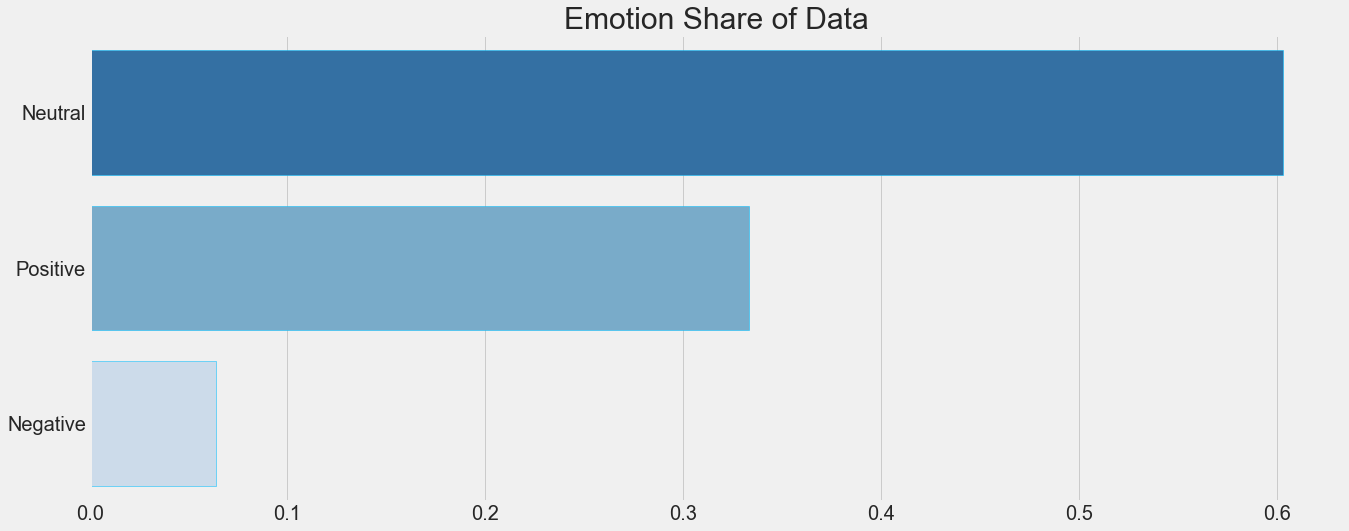

In [5]:
v.emotion_freqs(df)

<font size="4">`Neutral` accounts for 60% of the data.</font>

<font size="4">`Positive`                   accounts for 33% of the data.</font>

<font size="4">`Negative`                   accounts for 6% of the data.</font>

## Emotions by Brand
The vast majority of neutral tweets had null values in the `brand_product` column. After filtering the data down to tweets that had brand/product information attached to them, we visualized the level of each sentiment for the various brands/products.

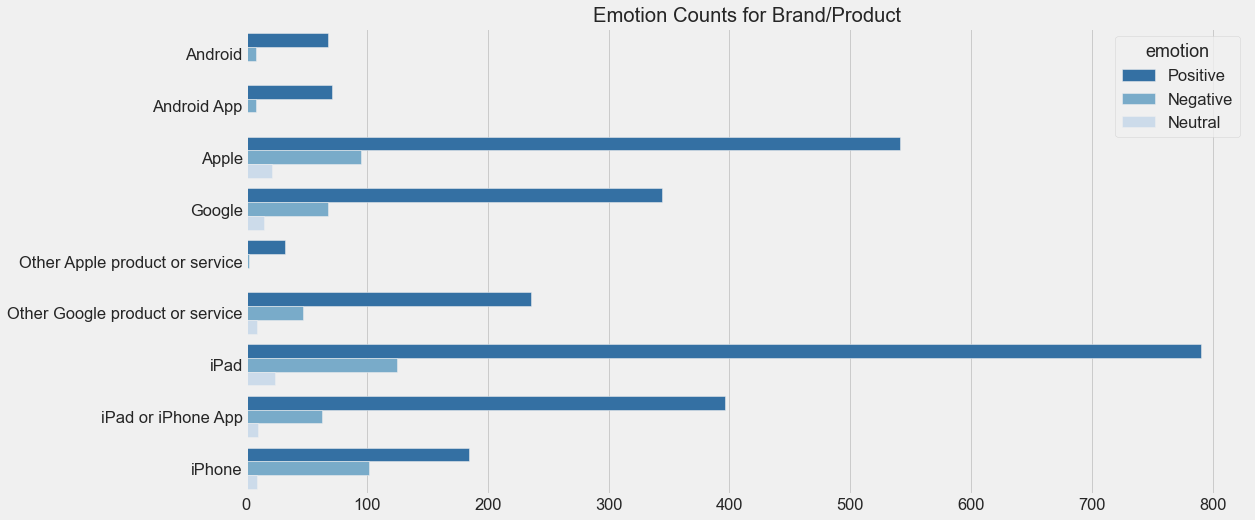

In [6]:
v.brand_emotions(df)

<font size="4">Apple dominates the tweets with `iPad`, `Apple`, and `iPad or iPhone App` being the subjects of the most tweets.</font>

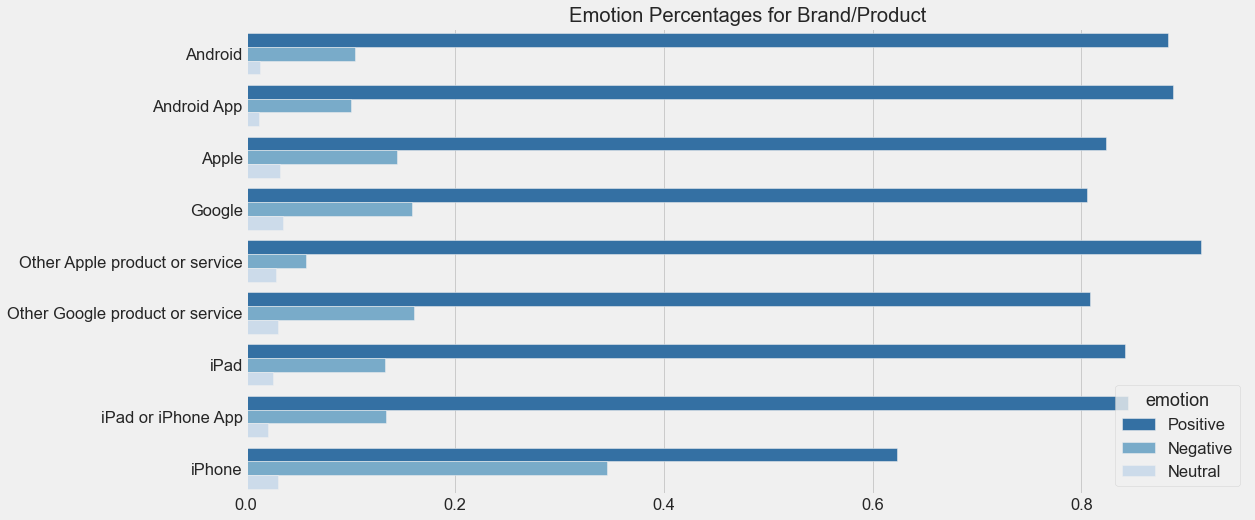

In [7]:
v.brand_emotion_n(df)

<font size="4">Tweets about product and brands have a strong positive skew, with the only exception being tweets about the iPhone. `iPhone` has a much higher ratio of negative to positives tweets than the other products and brands.</font>

## Word Clouds
Word clouds help to display the relative frequencies of words in the data in an intuitive way. The tweets were divided into positive, negative, and neutral, and word clouds were formed for each of the emotions. 

## Splitting Emotions for Word Clouds

In [8]:
# separating the the emotions
positive = df[df['emotion']=='Positive']
negative = df[df['emotion']=='Negative']
neutral = df[df['emotion']=='Neutral']

In [9]:
# censoring profanity in the tweets
pos_words = f.cloud_cleaner_lem(positive.lemmas)
neg_words = f.cloud_cleaner_lem(negative.lemmas)
neu_words = f.cloud_cleaner_lem(neutral.lemmas)

## Positive Word Cloud
The size of the word indicates its relative frequency in `Positive` tweets.

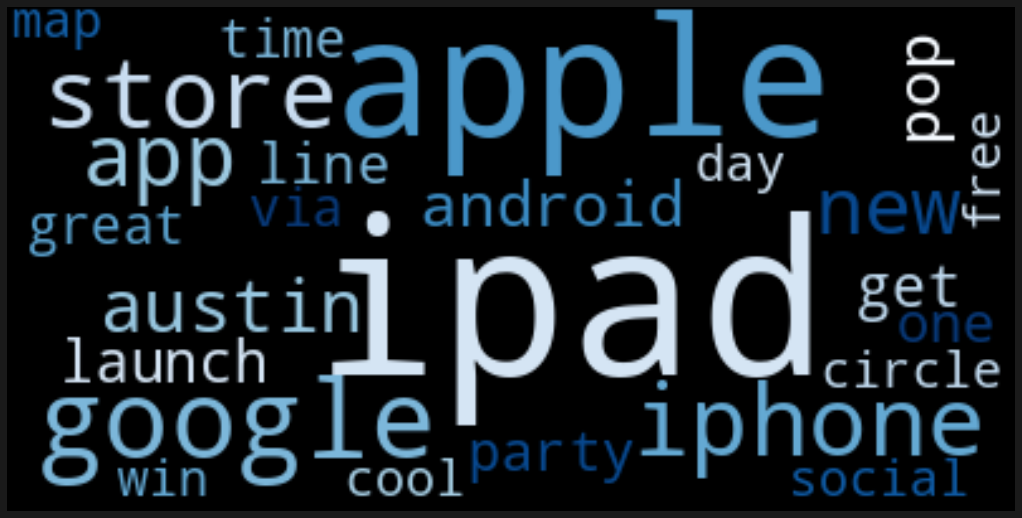

In [10]:
v.word_cloud(pos_words, 25)

<font size="4">`ipad`, `apple`, and `google` are the most used words in `Positive` tweets.</font>

## Negative Word Cloud
The size of the word indicates its relative frequency in `Negative` tweets.

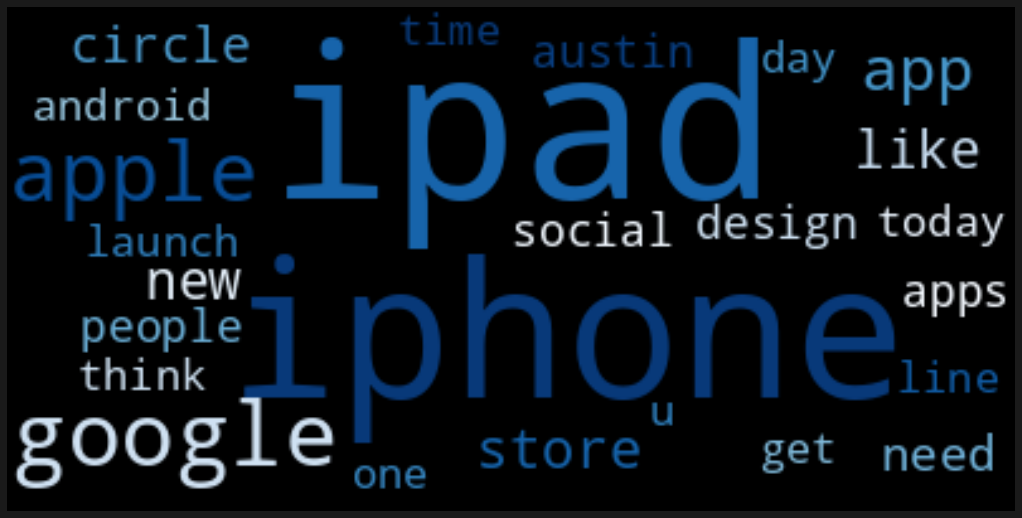

In [11]:
v.word_cloud(neg_words, 25)

<font size="4">`ipad`, `iphone`, and `google` are the most used words in `Negative` tweets.</font>

## Neutral Word Cloud
The size of the word indicates its relative frequency in `Neutral` tweets.

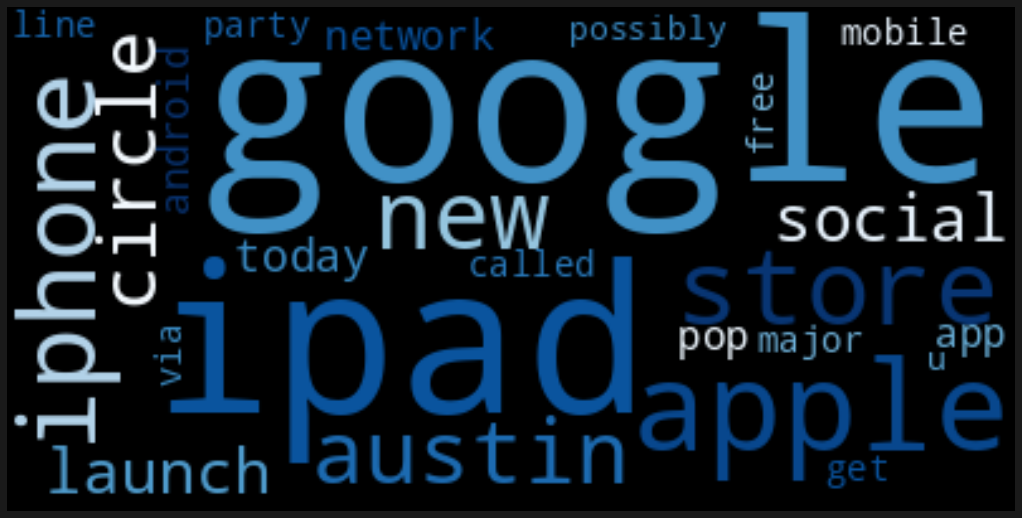

In [12]:
v.word_cloud(neu_words, 25)

<font size="4">`google`, `ipad`, and `apple` are the most used words in `Neutral` tweets.</font>

# Modeling
The data was filtered down to negative and positive tweets, and various binary classifiers were trained and tested during the modeling process. The results of these experiments are detailed below.

## Importing the Cleaned Original Modeling Data

In [13]:
path = os.path.join(gparent, 'data/processed', 'report_baseline.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`y_lem` column values = {1: 'negative', 0: 'positive'}</font>

In [14]:
# Creating data & target
X_lem = df.X_lem
y_lem = df.y_lem

In [15]:
# random_state = 2021
X_train, X_test, y_train, y_test = f.splitter(X_lem,
                                               y_lem)                                                                   

## Baseline Model
A baseline model was created from a pipeline consisting of a TFIDF vectorizer and a dummy classifier. The baseline model is configured to classify everything as the majority class: positive in the case of our data.

### Loading, Fitting & Scoring Model

In [16]:
# setting the path
path = os.path.join(gparent, 'models', 'baseline_model.pkl')

In [17]:
# loading the model
file = open(path, 'rb')
baseline = pickle.load(file)
file.close()

In [18]:
# fitting the model
baseline.fit(X_train, y_train);

### Scoring the Baseline Model on Test Data

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


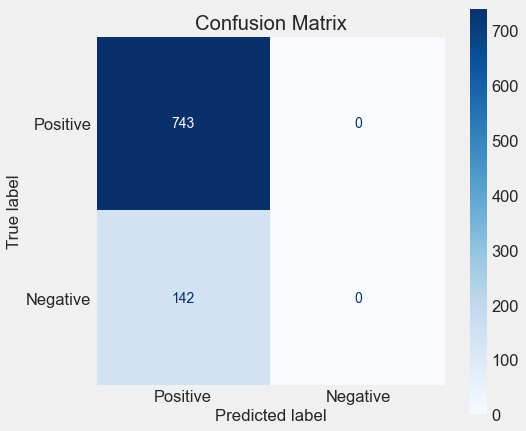

,F1,Recall,Precision
0,0.0,0.0,0.0


In [19]:
f.confusion_report(baseline, X_test, y_test)

<font size="4"> Baseline Scores: F1 = 0, Recall = 0, Precision = 0</font>

### Score Interpretation
F1 is a mix of both precision and recall, so the interpretation of the results is more easily given in terms of recall and precision. 
- From the confusion matrix we see that the baseline model is classifying everything as the majority class, which was expected.
- No tweets were correctly classified as negative, so the recall score for this model is 0. 
- No tweets were classified as negative, so the precision score (the proportion of tweets classified as negative that were truly negative) is 0 as well.

## First Simple Model
A first simple model was created from a pipeline consisting of a TFIDF vectorizer and a logistic regression classifier. Logistic regression was chosen as the first model because of its speed and ease of interpretability.

### Loading, Fitting & Scoring Model

In [20]:
# setting the path
path = os.path.join(gparent, 'models', 'simple_model.pkl')

In [21]:
# loading the model
file = open(path, 'rb')
simple = pickle.load(file)
file.close()

In [22]:
# fitting the model
simple.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


### Scoring the Model on Test Data

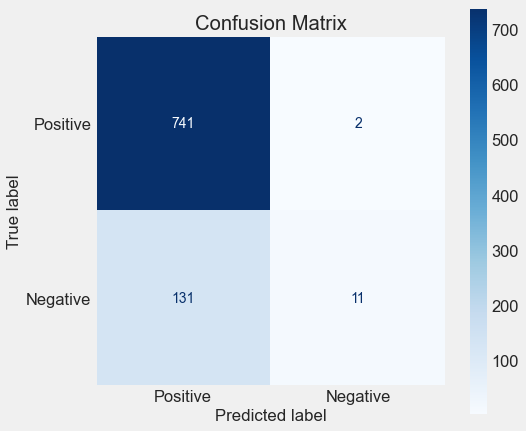

,F1,Recall,Precision
0,0.141935,0.077465,0.846154


In [23]:
f.confusion_report(simple, X_test, y_test)

<font size="4"> Scores: F1 = .14, Recall = .08, Precision = .85</font>

### Score Interpretation
Since F1 is a mix of both precision and recall, the interpretation of the results is more easily described in terms of recall and precision. 
- From the confusion matrix we see that the simple model is classifying nearly everything as the majority class.
- A recall score of .08 means that 8% of negative tweets were correctly classified as negative. 
- A precision score of .85 indicates that 85% of tweets classified as negative were truly negative.

While it was a slight improvement over the baseline model's, the performance of the first simple model was still very poor. It was only capturing 8% of our desired class, and that is insufficient for use in our business case.

#### Data Augmentation & Intermediate Models
The poor performance of the first simple model was largely due the the extreme class imbalance of the original data, so minority class oversampling and SMOTE methods were implemented. These strategies provided improved performance in the simple model, but the results were still unsatisfactory.  Various other model types were tested with the oversampled data, but the performance of these alternative models was also poor.

In the end, additional negative sentiment data obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets) and [data.world](https://data.world/crowdflower/apple-twitter-sentiment) were used to augment the baseline data. This new data greatly improved the performance of all the models. Some of the intermediate models are detailed below:

- Simple logistic regression: F1=.88, Recall=.81 Precision=.98 (Untuned)

- Tuned Naive Bayes classifier: F1=.86, Recall=.80 Precision=.93 (Tuned with GridSearchCV)

- Tuned XGBoost Classifier: F1=.88, Recall=.84, Precision=.93 (Tuned with RandomizedSearchCV)

Ultimately, the final model slightly improved on the metrics of the untuned logistic regression, naive Bayes classifier, and XGBoost Classifier to varying degrees. The performance of the XGBoost model was close to that of the final model, but came at the expense of considerably longer training and tuning times, a higher computational cost, and less interpretability.

## Importing the Augmented Data For EDA

In [24]:
path = os.path.join(gparent, 'data/processed', 'report_aug_viz.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Class Balance of the Augmented Data

In [25]:
df.emotion.value_counts(normalize=True)

Neutral     0.477762
Positive    0.264010
Negative    0.258228
Name: emotion, dtype: float64

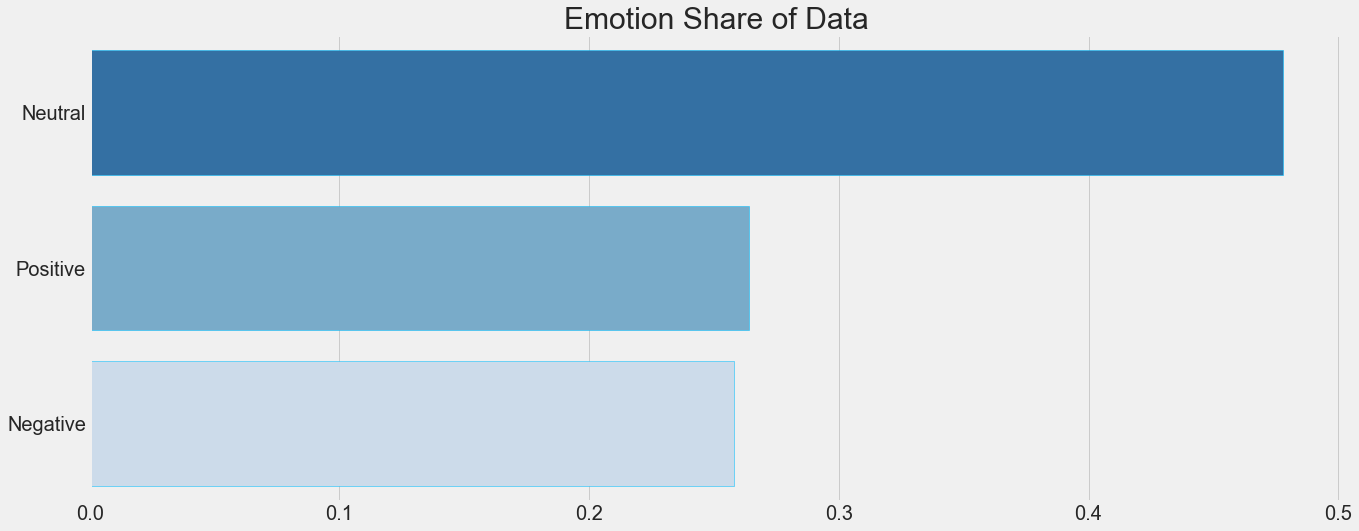

In [26]:
v.emotion_freqs(df)

<font size="4">`Neutral` accounts for 48% of the data.</font>

<font size="4">`Positive`                   accounts for 26% of the data.</font>

<font size="4">`Negative`                   accounts for 26% of the data.</font>

<font size="4">The class balance of the augmented data is much more reasonable for modeling purposes.</font> 

## Splitting Emotions for Word Clouds

In [27]:
# separating the the emotions
positive = df[df['emotion']=='Positive']
negative = df[df['emotion']=='Negative']
neutral = df[df['emotion']=='Neutral']

In [28]:
# censoring swear words for word clouds
pos_words = f.cloud_cleaner_lem(positive.lemmas)
neg_words = f.cloud_cleaner_lem(negative.lemmas)
neu_words = f.cloud_cleaner_lem(neutral.lemmas)

## Word Clouds for Augmented Data
Again, the largest the word the greater its frequency in the data.

## Positive Word Cloud

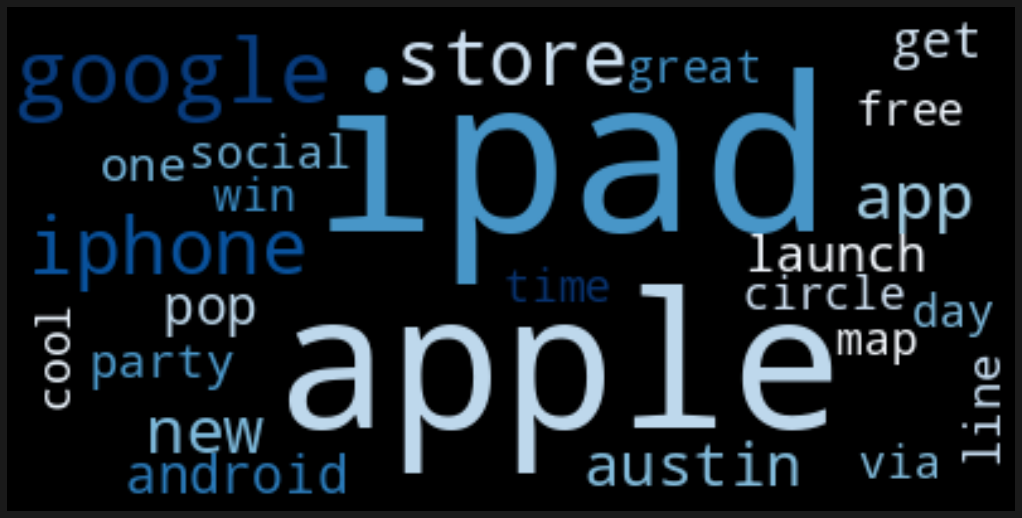

In [29]:
v.word_cloud(pos_words, 25)

<font size="4">`ipad`, and `apple` are the most used words in `Positive` tweets.</font>

## Negative Word Cloud

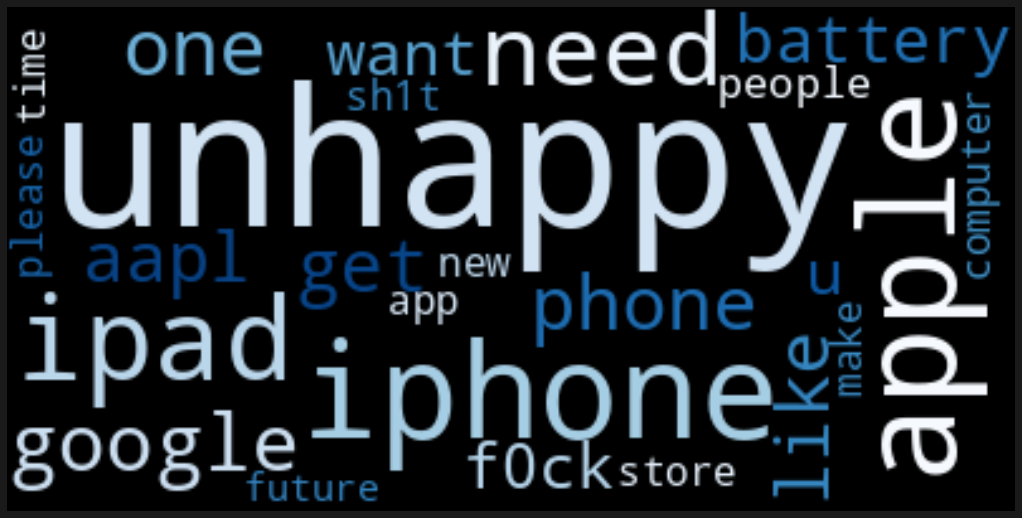

In [30]:
v.word_cloud(neg_words, 25)

<font size="4">`unhappy`, `apple`, and `iphone` are the most used words in `Negative` tweets.</font>

## Neutral Word Cloud

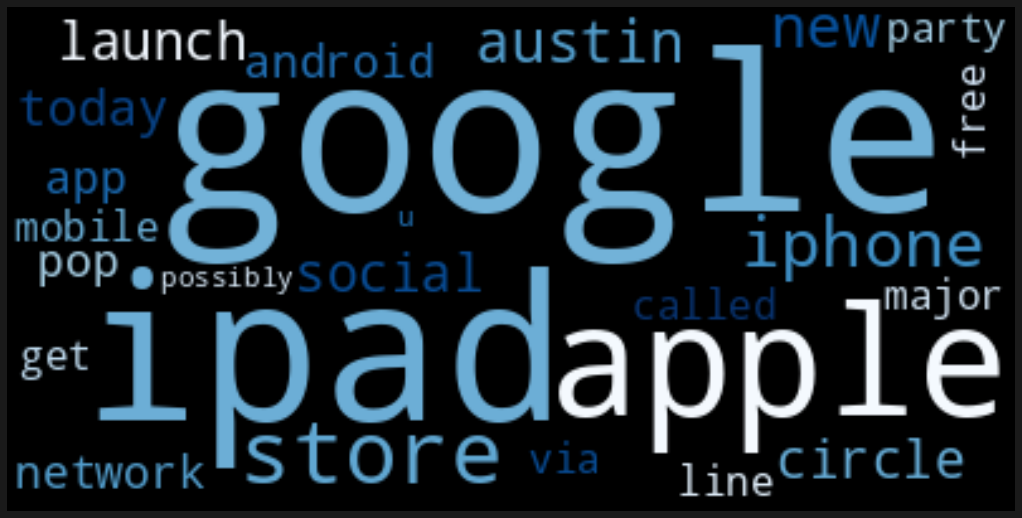

In [31]:
v.word_cloud(neu_words, 25)

<font size="4">`google` and `ipad`, are the most used words in `Neutral` tweets.</font>

## Loading the Augmented Data Modeling

In [32]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`y_lem_aug` column values = {1: 'negative', 0: 'positive'}</font>

In [33]:
# Creating data & target
X_lem_aug = df.X_lem_aug
y_lem_aug = df.y_lem_aug

In [34]:
# train-test split
X_aug_train, X_aug_test, y_aug_train, y_aug_test = f.splitter(X_lem_aug,
                                                               y_lem_aug)            

# Final Model:
<font size="4">Logistic Regression CLF Tuned on Augmented Lemmatized Data</font>

<font size="4">Metrics: F1=.89, Recall=.83, Precision=.97</font>

A TFIDF vectorizer was used for feature engineering and vectorization.

Given its overall performance, the tuned logistic regression model is the final choice for this project due to its greater training, tuning, and prediction speeds, as well as its lower computational cost.

### Loading and Fitting the Model

In [35]:
# setting the path 
path = os.path.join(gparent, 'models', 'LR_model.pkl')

# loading the model
file = open(path, 'rb')
tuned_LR_aug = pickle.load(file)
file.close()

# fitting the model
tuned_LR_aug.fit(X_aug_train, y_aug_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

### Scoring the Model on Test Data

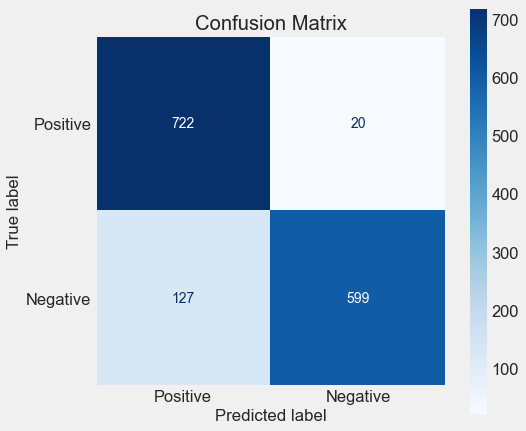

,F1,Recall,Precision
0,0.890706,0.825069,0.96769


In [36]:
f.confusion_report(tuned_LR_aug, X_aug_test, y_aug_test)

### Score Interpretation
From the confusion matrix we see that the model still has a little trouble classifying negatives relative to positives, but the overall performance is acceptable.

- The augmentation of the dataset has greatly improved model performance.
- A recall score of .83 means that 83% of negative tweets were correctly classified as negative. 
- A precision score of .97 indicates that 97% of tweets classified as negative were truly negative.

### Feature Coefficients

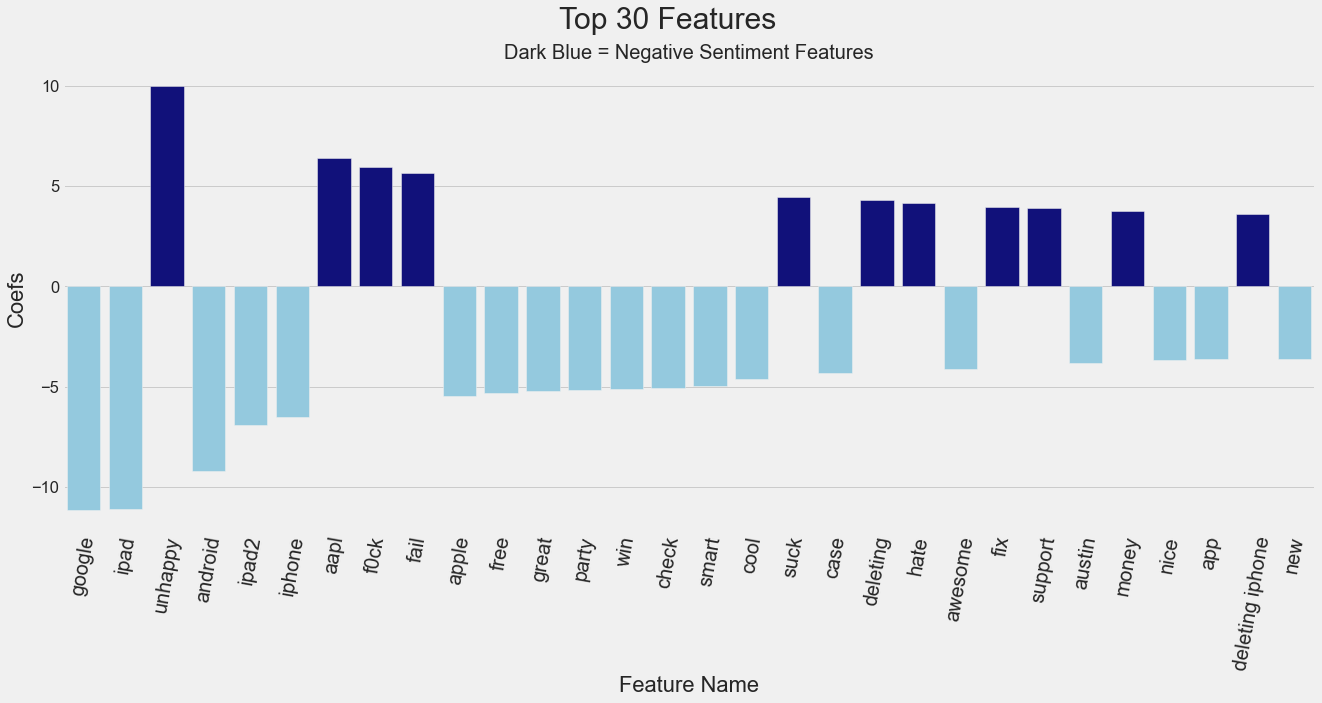

In [37]:
v.base_coefs(tuned_LR_aug)

### Notes on the Features

`google` & `ipad` have the largest coefficients driving positive classifications, while `unhappy` and `aapl` have the largest coefficients driving negative classifications. Most brand signifiers are still associated with positive classifications.

### Relative Odds

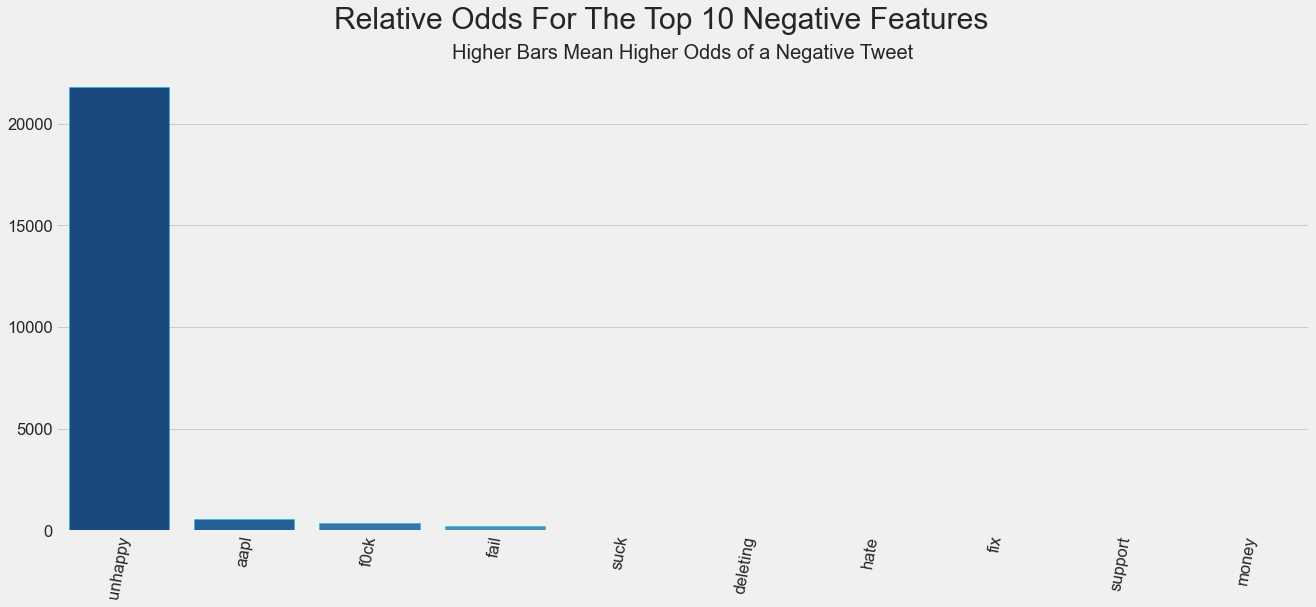

In [44]:
v.base_neg_odds(tuned_LR_aug)

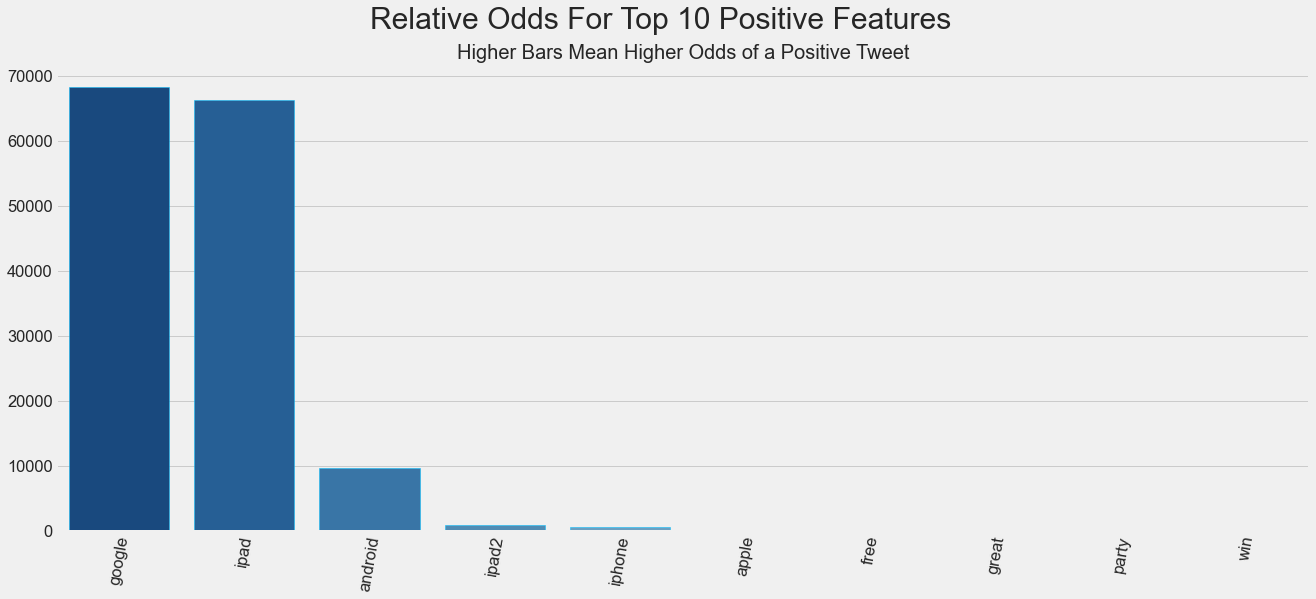

In [45]:
v.base_pos_odds(tuned_LR_aug)

### Interpretation of the Odds
A higher bar means a greater relative importance of the feature to the model. Again, google and ipad are the greatest factors driving positive classifications, while unhappy and aapl are driving negative classifications. unhappy increases the odds of a negative classification most significantly.

# Alternate Model: 
<font size="4">Random Forest CLF Tuned on Augmented Lemmatized Data</font>

Again, a TFIDF vectorizer was implemented for feature engineering and vectorization.

The performance of the random forest model is comparable  to that of the the logistic regression model, albeit with slightly higher recall and slightly lower precision. However, it is slower and more computationally expensive. If the highest possible recall is needed, and speed and computational power are of minimal concern, then this model might be preferable.

### Loading & Fitting Model

In [40]:
# setting the path
path = os.path.join(gparent, 'models', 'RF_model.pkl')

# loading the model
file = open(path, 'rb')
tuned_rf_aug = pickle.load(file)
file.close()

# fitting model
tuned_rf_aug.fit(X_aug_train, y_aug_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

### Scoring the Model on Test Data

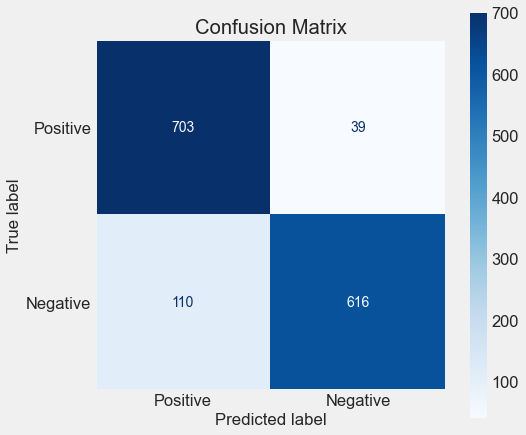

,F1,Recall,Precision
0,0.892107,0.848485,0.940458


In [41]:
f.confusion_report(tuned_rf_aug, X_aug_test, y_aug_test)

<font size="4">Metrics: F1=.89, Recall=.85, Precision=.94</font>

### Score Interpretation
From the confusion matrix we see that the model still has a little trouble classifying negatives relative to positives, but the overall performance is acceptable.

- A recall score of .85 means that 85% of negative tweets were correctly classified as negative. 
- A precision score of .94 indicates that 94% of tweets classified as negative were truly negative.

### Feature Importances

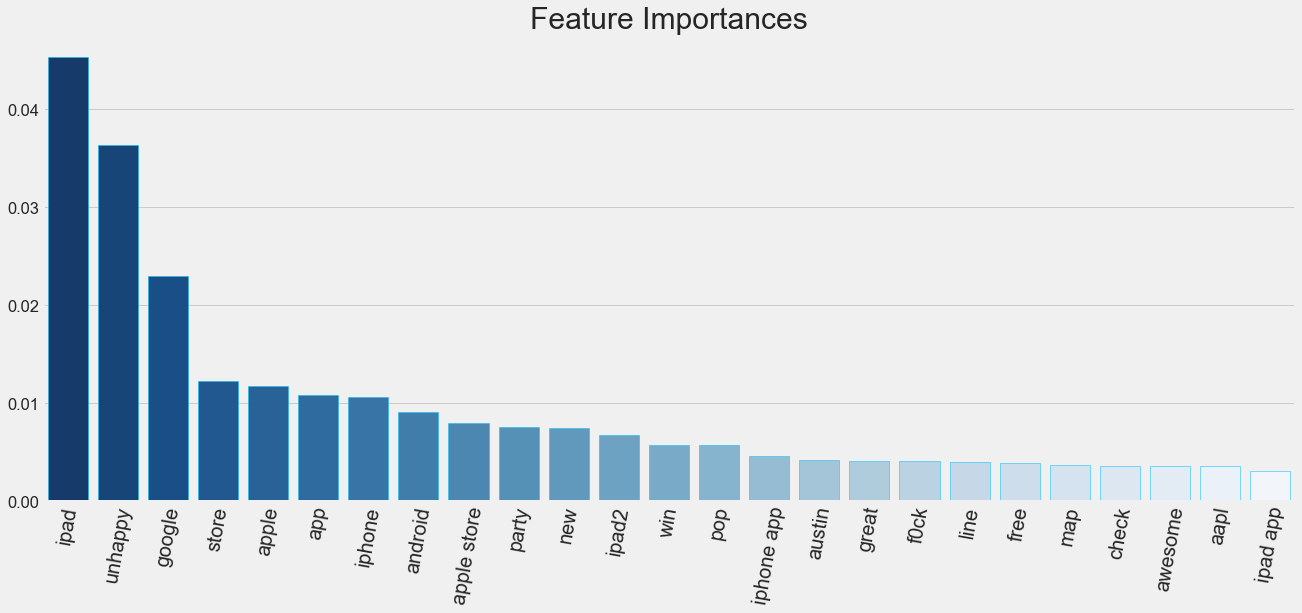

In [42]:
v.feature_plot(tuned_rf_aug)

### Notes on the Features

`ipad` and `unhappy` are again the most important tokens driving the model, and six of the top ten features are brand signifiers.

# Conclusion
A tuned logistic regression model was chosen as the final model of the project, and an F1 accuracy score of .89 (recall=.83, precision=.97) achieved at the end of the modeling process. The recall score of .83 meant that 83% of negative tweets were correctly classified as negative, and the precision score of .97 indicated that 97% of tweets classified as negative were truly negative. 

An alternate random forest classifier with a F1 accuracy score of .89 (recall=.85, precision=.94) is also available for use if a higher recall is the most pressing concern.

# Next Steps

Next steps for the project include:
- Using an advanced word embedding method and tuning an RNN classifier.
- Implementing a multiclass classifier and adding neutral tweets to the model. 
- Further investigating the final model's adherence to the underlying assumptions of logistic regression.